In [65]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import math as m
from cvxopt import matrix, solvers
import cvxopt
from sklearn.metrics import accuracy_score

### SVM实则为非线性规划----二次规划，凸规划问题

#### 线性规划很好理解，高中就有，二次规划则需要用到cvxopt包求解

### SVM的核心是将其转化为二次规划问题
#### SVM子问题是寻找一个margin的问题
#### 也就是最大化支持向量到超平面的距离
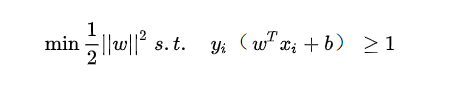

#### Here I use cvxopt to solves the quadratic program
The main form of quadratic program is 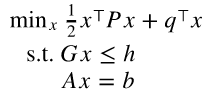
$P, q$ define the objective  
$G, h$ are all the inequality constraints  
$A, b$ are all the equality constraints  

In [38]:
# read train and test data
train_data = pd.read_csv('train.csv',header=None)
test_data = pd.read_csv('test.csv',header=None)

In [3]:
# rate of train/test is 0.85:0.15, with total 200 explantory variables and 1 response variable 
train_data.shape,test_data.shape

((8500, 201), (1500, 201))

As mentioned in report, primal SVM : $$
\begin{aligned}
\min_{w, b, \xi}  \, \frac{1}{2}w^\top w + C \mathbf{1}^\top \xi \\
\mathrm{s.t. } \,  \xi \geq 0 \\
 y_i x_i^\top w + y_i b + \xi_i\geq 1
\\
\end{aligned}
$$

dual SVM will be: $$
\begin{aligned}
\max_\alpha  \, \mathrm{1}^\top\alpha -\frac{1}{2}\alpha^\top X_y^T X_y \alpha \\
\mathrm{s.t. } \,  \alpha \geq 0 \\
 \alpha \leq C \\
 y^\top\alpha = 0
\\
\end{aligned}
$$

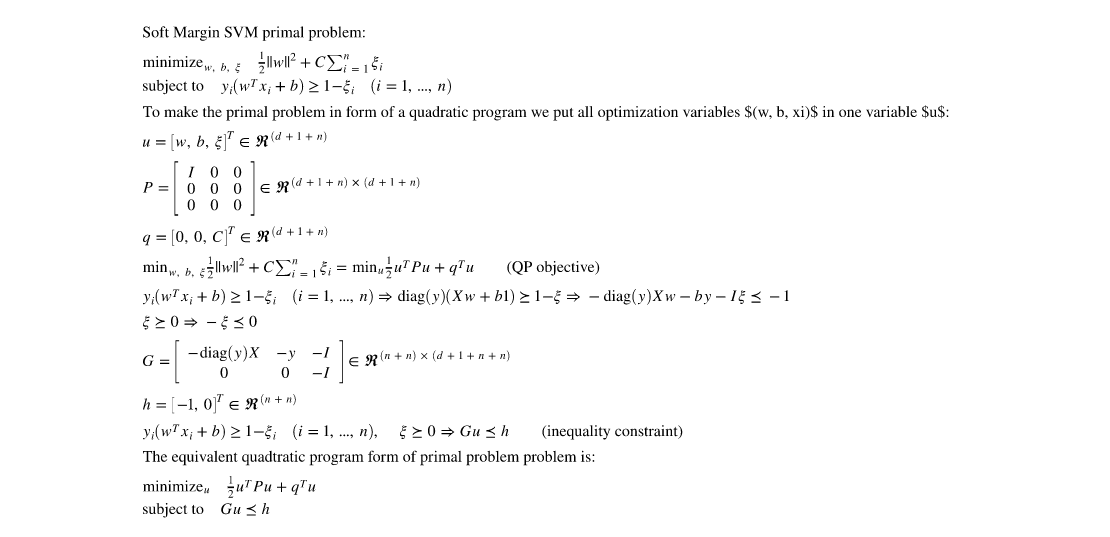

In [2]:
#https://github.com/arashabzd/soft-margin-svm-cvxopt/blob/master/SVM.ipynb

https://zhuanlan.zhihu.com/p/100041443

In [15]:
#Primal soft margin

def svm_train_primal(X,y,C):
    """
    Find w directly, A,b = None
    """
    # P = Diagnal Matix
    n,p = X.shape
    diag_P = np.hstack([np.ones(n), np.zeros(p + 1)])
    P = np.diag(diag_P)

    Xy = np.diag(y).dot(X)
    
    q = np.hstack([np.zeros(p + 1), C * np.ones(n)])
    # y(wx+b)+ei>=1
    G1 = - np.hstack([Xy, y[:, np.newaxis], np.eye(n)])
    # ei>=0
    G2 = - np.hstack([np.zeros((n, p+1)), np.eye(n)])
    G = np.vstack([G1, G2])
    h = - np.hstack([np.ones(n), np.zeros(n)])
    
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
           
    svm_model = np.array(cvxopt.solvers.coneqp(P,q,G,h)['x']).flatten()
    
    return svm_model

def svm_predict_primal(data_test, label_test, svm_model):
    n,p = data_train.shape

    y_pred = np.dot(data_test, svm_model[:p])+svm_model[-1]
    # change to -1 or 1
    y_pred = np.sign(y_pred)
    
    score = accuracy_score(label_test, y_pred)
    return score

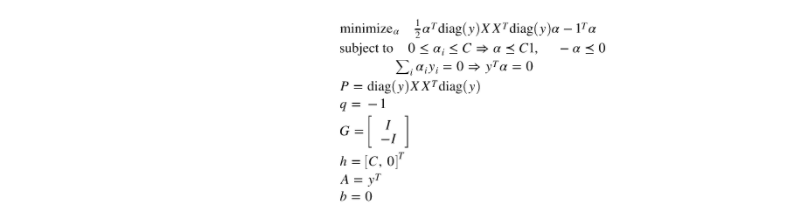

In [36]:
#Dual soft margin

def svm_train_dual(X,y,C):
    """
    P = (X^T)X    
    q = -1(1*n_samples)
    G = -1(n_samples*n_samples)
    h = 0(1*n_samples), C(1*n_samples)
    A = y^T 
    b = 0 
    """
    n,p = X.shape
    y = y.reshape(-1,1) * 1.
    X_d = y * X  
    P = cvxopt.matrix(np.dot(X_d , X_d.T) * 1.)
    q = cvxopt.matrix(-np.ones((n, 1)))
    G = cvxopt.matrix(np.vstack((np.eye(n)*-1,np.eye(n))))
    h = cvxopt.matrix(np.hstack((np.zeros(n), np.ones(n) * C/n)))
    A = cvxopt.matrix(y.reshape(1, -1))
    b = cvxopt.matrix(np.zeros(1))
    
    solv = solvers.qp(P, q, G, h, A, b)
    
    alpha = np.array(solv['x'])
    # get params w and b
    w = ((y * alpha).T @ X).reshape(-1,1)
    S = (alpha > 1e-4).flatten()
    b = y[S] - np.dot(X[S], w)
    b = b.mean()
    svm_model_d = np.vstack((w,b))
    return svm_model_d

def svm_predict_dual(data_test, label_test, svm_model_d):    
    m,n = data_train.shape
    y_pred = np.dot(svm_model_d[:n].T, data_test.T)+svm_model_d[-1]
    y_pred = np.sign(y_pred)
    y_pred = y_pred.reshape(label_test.shape)
    score = accuracy_score(label_test, y_pred)
    return score

In [58]:
# random split 0.85:0.15 for cv
data_train = train_data.sample(frac=0.85)
data_val = train_data[~train_data.index.isin(data_train.index.tolist())]

label_train = data_train[0]
label_val = data_val[0]

data_train = data_train.iloc[:,1:]
data_val = data_val.iloc[:,1:]

data_train = data_train.to_numpy()
data_val = data_val.to_numpy()
label_train = label_train.to_numpy()
label_val = label_val.to_numpy()

data_test = test_data.iloc[:,1:]
label_test = test_data.iloc[:,0]
data_test = data_test.to_numpy()
label_test = label_test.to_numpy()

# replace label 0 to -1
label_train = np.where(label_train==0, -1, label_train) 
label_val = np.where(label_val==0, -1, label_val) 
label_test = np.where(label_test==0, -1, label_test)

In [62]:
# param tuning
import datetime
C_lst = [1, 4, 8, 16, 32, 64, 128]
for regularisation_para_C in C_lst:
    t1 = datetime.datetime.now()
    svm_model = svm_train_primal(data_train , label_train , regularisation_para_C)
    test_accuracy = svm_predict_primal(data_val , label_val, svm_model)
    t2 = datetime.datetime.now()
    cost = (t2 - t1).seconds
    print('primal SVM with regularisation_para_C: {} ,get acc: {}, spend {} seconds'.format(regularisation_para_C,test_accuracy,cost)) 
    t1 = datetime.datetime.now()
    svm_model_d = svm_train_dual(data_train , label_train , regularisation_para_C)
    test_accuracy_d = svm_predict_dual(data_val,label_val ,svm_model_d)
    t2 = datetime.datetime.now()
    cost = (t2 - t1).seconds    
    print('dual SVM with regularisation_para_C: {} ,get acc: {}, spend {} seconds'.format(regularisation_para_C,test_accuracy_d,cost)) 

     pcost       dcost       gap    pres   dres
 0: -2.2521e+03  1.1868e+04  1e+05  5e+00  6e+02
 1:  8.0468e+03 -1.0031e+04  3e+04  7e-01  9e+01
 2:  3.5974e+03 -1.1478e+03  6e+03  1e-01  1e+01
 3:  1.6493e+03  4.3478e+02  1e+03  2e-02  3e+00
 4:  1.1802e+03  7.0913e+02  5e+02  6e-03  7e-01
 5:  1.1015e+03  7.5850e+02  4e+02  3e-03  5e-01
 6:  1.0146e+03  8.0885e+02  2e+02  1e-03  2e-01
 7:  9.5955e+02  8.4132e+02  1e+02  6e-04  9e-02
 8:  9.2272e+02  8.6348e+02  6e+01  2e-04  3e-02
 9:  9.0023e+02  8.7631e+02  2e+01  1e-15  8e-13
10:  8.9113e+02  8.8393e+02  7e+00  1e-15  2e-12
11:  8.8813e+02  8.8655e+02  2e+00  1e-15  3e-12
12:  8.8736e+02  8.8724e+02  1e-01  1e-15  4e-12
13:  8.8730e+02  8.8729e+02  7e-03  1e-15  4e-12
14:  8.8730e+02  8.8730e+02  2e-04  1e-15  2e-11
Optimal solution found.
primal SVM with regularisation_para_C: 1 ,get acc: 0.9019607843137255, spend 94 seconds
     pcost       dcost       gap    pres   dres
 0: -7.0314e+02 -2.3730e+00  7e+04  3e+02  7e-13
 1: -7.2

 2: -2.3305e+04 -1.7339e+05  5e+05  2e+00  7e+00
 3:  5.2096e+04 -3.8919e+04  2e+05  6e-01  2e+00
 4:  3.8213e+04  1.1212e+03  6e+04  1e-01  4e-01
 5:  3.3627e+04  6.5200e+03  4e+04  7e-02  2e-01
 6:  2.8174e+04  9.1439e+03  2e+04  3e-02  1e-01
 7:  2.5779e+04  1.0328e+04  2e+04  2e-02  7e-02
 8:  2.4335e+04  1.1241e+04  2e+04  1e-02  4e-02
 9:  2.3166e+04  1.1784e+04  1e+04  7e-03  2e-02
10:  2.1187e+04  1.2396e+04  9e+03  4e-03  1e-02
11:  2.0262e+04  1.2714e+04  8e+03  3e-03  9e-03
12:  1.8725e+04  1.3259e+04  6e+03  1e-03  4e-03
13:  1.7724e+04  1.3666e+04  4e+03  6e-04  2e-03
14:  1.7278e+04  1.3849e+04  4e+03  4e-04  1e-03
15:  1.6720e+04  1.4083e+04  3e+03  3e-04  9e-04
16:  1.6299e+04  1.4226e+04  2e+03  1e-04  4e-04
17:  1.5817e+04  1.4485e+04  1e+03  7e-05  2e-04
18:  1.5439e+04  1.4688e+04  8e+02  2e-05  8e-05
19:  1.5263e+04  1.4794e+04  5e+02  1e-05  4e-05
20:  1.5114e+04  1.4892e+04  2e+02  4e-06  1e-05
21:  1.5039e+04  1.4946e+04  9e+01  1e-06  3e-06
22:  1.5008e+04  1.4

In [82]:
from sklearn.svm import LinearSVC
for i in [1, 4, 8, 16, 32, 64, 128]:
    t1= datetime.datetime.now()
    print(LinearSVC(C=i).fit(data_train ,label_train).score(data_val,label_val))
    t2 = datetime.datetime.now()
    print((t2 - t1).seconds)

0.9654901960784313
0
0.9639215686274509
0
0.9576470588235294
1
0.9584313725490196
0
0.9443137254901961
1
0.952156862745098
1
0.9349019607843138
1


In [67]:
# best param to test
t1 = datetime.datetime.now()
svm_model = svm_train_primal(data_train,label_train ,64)
test_accuracy = svm_predict_primal(data_test,label_test,svm_model)
t2 = datetime.datetime.now()
cost = (t2 - t1).seconds
print('primal SVM with regularisation_para_C: {} ,get acc: {}, spend {} seconds'.format(64,test_accuracy,cost)) 

t1 = datetime.datetime.now()
svm_model_d = svm_train_dual(data_train , label_train , 4)
test_accuracy_d = svm_predict_dual(data_test,label_test,svm_model_d)
t2 = datetime.datetime.now()
cost = (t2 - t1).seconds    
print('dual SVM with regularisation_para_C: {} ,get acc: {}, spend {} seconds'.format(4,test_accuracy_d,cost)) 

t1= datetime.datetime.now()
print(LinearSVC(C=1).fit(data_train ,label_train).score(data_test,label_test))
t2 = datetime.datetime.now()
print((t2 - t1).seconds)

     pcost       dcost       gap    pres   dres
 0: -1.0845e+07  5.8534e+06  3e+07  9e+01  1e+02
 1: -1.7730e+06 -2.7060e+06  9e+06  2e+01  3e+01
 2: -1.8260e+05 -6.8822e+05  2e+06  4e+00  7e+00
 3:  1.4435e+05 -1.7110e+05  7e+05  1e+00  2e+00
 4:  1.1110e+05 -5.9103e+03  2e+05  2e-01  3e-01
 5:  7.6816e+04  1.3321e+04  9e+04  7e-02  1e-01
 6:  6.6485e+04  1.7174e+04  6e+04  4e-02  6e-02
 7:  5.7713e+04  1.9563e+04  5e+04  2e-02  3e-02
 8:  5.3052e+04  2.1204e+04  4e+04  1e-02  2e-02
 9:  4.8470e+04  2.2709e+04  3e+04  7e-03  1e-02
10:  4.6216e+04  2.3477e+04  2e+04  4e-03  6e-03
11:  4.1644e+04  2.4620e+04  2e+04  2e-03  3e-03
12:  4.0112e+04  2.5038e+04  2e+04  2e-03  2e-03
13:  3.7184e+04  2.5984e+04  1e+04  8e-04  1e-03
14:  3.5512e+04  2.6589e+04  9e+03  4e-04  7e-04
15:  3.4339e+04  2.6941e+04  7e+03  2e-04  4e-04
16:  3.2588e+04  2.7733e+04  5e+03  1e-04  2e-04
17:  3.2100e+04  2.7850e+04  4e+03  7e-05  1e-04
18:  3.1309e+04  2.8221e+04  3e+03  4e-05  6e-05
19:  3.0476e+04  2.86

In [98]:
# confusion matrix
from sklearn.metrics import confusion_matrix as cm
m,n = data_train.shape
y_pred_d = np.dot(svm_model_d[:n].T, data_test.T)+svm_model_d[-1]
y_pred_d = np.sign(y_pred_d)
y_pred_d = y_pred_d.reshape(label_test.shape)

y_pred = np.dot(data_test, svm_model[:n])+svm_model[-1]
# change to -1 or 1
y_pred = np.sign(y_pred)

print(cm(y_pred,label_test)),
print(cm(y_pred_d,label_test)),
print(cm(LinearSVC(C=1).fit(data_train ,label_train).predict(data_test),label_test))

[[753 145]
 [  6 596]]
[[737  15]
 [ 22 726]]
[[730  14]
 [ 29 727]]


In [89]:
# Plot
from sklearn.decomposition import PCA
pX = PCA(n_components=2).fit_transform(data_test)
pX = pX[200:300]
pY = label_test[200:300]

Text(0.5, 1.0, 'C=1')

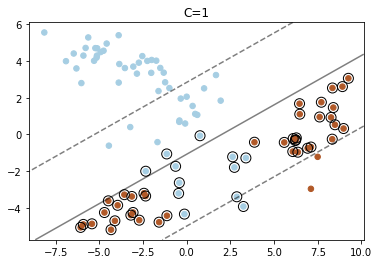

In [99]:
decision_function = LinearSVC(C=1).fit(pX,pY).decision_function(pX)
support_vector_indices = np.where((2 * pY - 1) * decision_function <= 1)[0]
support_vectors = pX[support_vector_indices]

plt.scatter(pX[:, 0], pX[:, 1], c=pY, s=30, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = LinearSVC(C=1).fit(pX,pY).decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')
plt.title("C=" + str(1))

In [92]:
support_vectors

array([[-0.41799582, -2.63156378],
       [-4.70420591, -4.25343512],
       [ 2.63220819, -1.22114705],
       [-3.56588751, -3.28078081],
       [ 8.26359244,  0.92503986],
       [-4.48039579, -3.61708948],
       [-6.06583269, -5.06427851],
       [-0.12671924, -4.34043459],
       [ 6.22015564, -0.33738864],
       [-2.34813802, -3.35507593],
       [-2.71137731, -4.67091057],
       [ 7.11473722, -0.6889857 ],
       [ 7.70972451,  1.75075601],
       [ 6.09790909, -0.22642219],
       [ 2.73445096, -1.79498409],
       [ 6.36577829, -0.96936176],
       [ 8.48806893,  0.52542885],
       [ 9.2563908 ,  3.05249389],
       [-0.63218199, -1.73743329],
       [-3.19332702, -4.39670192],
       [ 8.39469388,  1.46075435],
       [-2.3420452 , -2.00616818],
       [ 6.46071423,  1.67203517],
       [ 8.91582448,  2.60182938],
       [-5.41966135, -4.86909628],
       [ 8.98027164,  0.3193899 ],
       [-4.10648878, -4.70627238],
       [ 6.47432164,  1.10029049],
       [ 0.76543174,